# Hard Contrastraint Div Free on Turbulent Data

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

# verify cuda
torch.cuda.is_available()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
# device = 'cpu'

cuda:0


In [4]:
from turboflow.utils import phy_utils as phy
from turboflow.utils import dsp_utils as dsp

## Input data

Original size 256
Y shape (256, 256, 2)
Y min, max: -2.382122 2.999472
after normalization, Y min, max: -0.7941804424245333 1.0
Warning *** CHECK THE GRADIENT DIRECTION
Warning *** CHECK THE GRADIENT DIRECTION


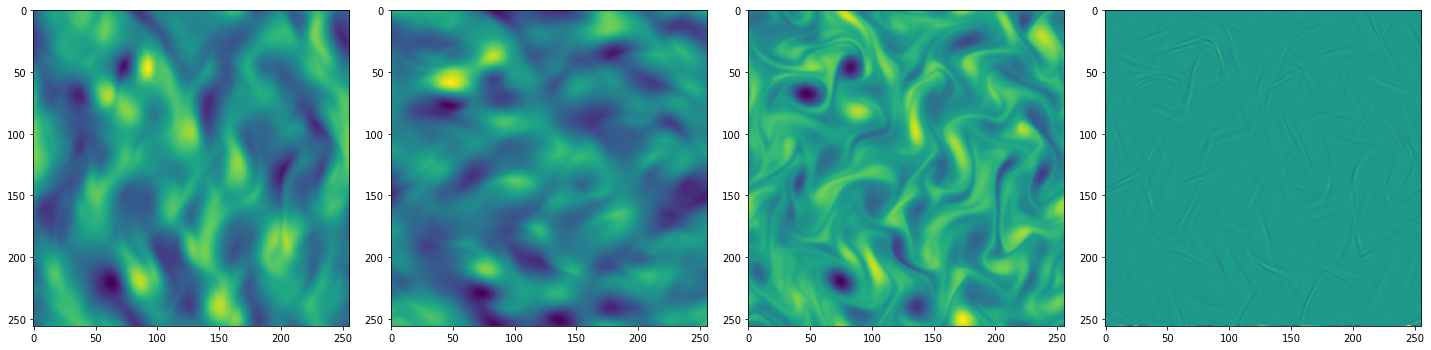

In [5]:
## SET UP DATA
path_to_data = '../data/2021-Turb2D_velocities.npy'
IMGs = np.load(path_to_data)
img_index = 42
X = IMGs[img_index,:,:,:2] / 255
U = IMGs[img_index,:,:,2:]
t = np.arange(0,IMGs.shape[0],step=0.01)
Re = 3900

original_size = X.shape[0]
print('Original size', original_size)

# normalize output
y = U.copy()
print('Y shape', y.shape)
print('Y min, max:', np.min(y), np.max(y))
y = y / np.max(np.abs(y))
print('after normalization, Y min, max:', np.min(y), np.max(y))

ytest = y.copy()
Xtest = X.copy()

W = phy.compute_vorticity(U[:,:,0],U[:,:,1])
D = phy.compute_divergence(U[:,:,0],U[:,:,1])

plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(U[:,:,0])
plt.subplot(142)
plt.imshow(U[:,:,1])
plt.subplot(143)
plt.imshow(W)
plt.subplot(144)
plt.imshow(D)
plt.tight_layout()
plt.show()

Xtrain shape: (64, 64, 2)
ytrain shape: (64, 64, 2)


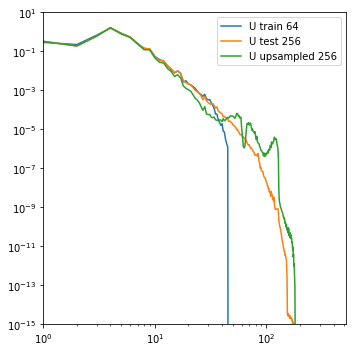

In [6]:
# downsampled resultion
scale = 1/4
coords = np.linspace(0, 1, int(original_size * scale), endpoint=False)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
tmp = coords[:,:,0].copy()
coords[:,:,0] = coords[:,:,1]
coords[:,:,1] = tmp
Xtrain = coords
print('Xtrain shape:', Xtrain.shape)

y1ds = dsp.interpolate2D(X, y[:,:,0], scale=scale)[:,:,None]
y2ds = dsp.interpolate2D(X, y[:,:,1], scale=scale)[:,:,None]
ytrain = np.concatenate([y1ds, y2ds], axis=-1)
print('ytrain shape:', ytrain.shape)

# upsampled resolution
yup = dsp.interpolate2D(Xtrain, ytrain[:,:,0], scale=4)[:,:,None]

# b1, b0, _r, _p_val, _stderr = stats.linregress(np.log10(mx), np.log10(my)) 

fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.loglog(np.arange(len(phy.powerspec(ytrain[:,:,0]))), phy.powerspec(ytrain[:,:,0]), label='U train 64')
axs.loglog(np.arange(len(phy.powerspec(ytest[:,:,0]))), phy.powerspec(ytest[:,:,0]), label='U test 256')
axs.loglog(np.arange(len(phy.powerspec(yup[:,:,0]))), phy.powerspec(yup[:,:,0]), label='U upsampled 256')
axs.set_ylim(10**(-15), 10)
axs.set_xlim(1, 512)
axs.legend()
plt.tight_layout()
plt.show()

# Dataset

In [7]:
class MyDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X, y):

        assert np.max(np.abs(y)) <= 1
        assert np.max(np.abs(X)) <= 1

        'Initialization'
        print('X shape', X.shape)
        print('y shape', y.shape)
        try:
            assert X.shape[0] == y.shape[0]
            assert X.shape[1] == y.shape[1]
        except:
            print('*** Dimension error ***')
            print('X', X.shape)
            print('y', y.shape)
            
        H, W, Cin = X.shape
        H, W, Cout = y.shape
        
        # reshape s.t. B = H*W of query points
        X = X.reshape(H*W, Cin)
        y = y.reshape(H*W, Cout)
        
        self.size = H*W
        # convert to torch and add an empty dimension for the batch
        self.inputs = torch.from_numpy(X).float() #XY x 2 (x,y)
        self.target = torch.from_numpy(y).float()  #XxYx3 (RGB)
        
        assert self.inputs.shape[0] == self.target.shape[0]
        assert self.inputs.shape[1] == self.target.shape[1]
        
        print(self.inputs.shape)
        print(self.inputs.shape)

    def __len__(self):
        'Denotes the total number of samples'
        return self.size

    def __getitem__(self, idx):
        'Generates one sample of data'
        # Load data and get label
        X = self.inputs[idx,...]
        y = self.target[idx,...]

        return X, y


class DataModule(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, 
                 batch_size=2000, num_workers=8):
        
        super().__init__()
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.train_data = train_data
        self.test_data = test_data
        self.val_data = val_data
        
    def prepare_data(self):
        self.train_dataset = MyDataset(self.train_data[0], self.train_data[1])
        self.val_dataset = MyDataset(self.val_data[0], self.val_data[1])
        self.test_dataset = MyDataset(self.test_data[0], self.test_data[1])
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, 
                          self.batch_size, num_workers = self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, 
                          self.batch_size, num_workers = self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, 
                          self.batch_size, num_workers = self.num_workers)

In [8]:
low_scale = 1/2
Xlow = np.concatenate([
            dsp.interpolate2D(X, Xtest[:,:,0], scale=low_scale)[:,:,None],
            dsp.interpolate2D(X, Xtest[:,:,1], scale=low_scale)[:,:,None]], 
       axis=-1)
ylow = np.concatenate([
            dsp.interpolate2D(X, ytest[:,:,0], scale=low_scale)[:,:,None],
            dsp.interpolate2D(X, ytest[:,:,1], scale=low_scale)[:,:,None]],
        axis=-1)

dm = DataModule(
    train_data=[Xlow, ylow],
    val_data=[Xlow, ylow],
    test_data=[Xlow, ylow],
    batch_size = 128**2,
)

## test
dm.prepare_data()
print('Train')
for batch in dm.train_dataloader():
    x, y = batch
    print(x.shape, y.shape)
    
print('Validation')
for batch in dm.val_dataloader():
    x, y = batch
    print(x.shape, y.shape)

X shape (128, 128, 2)
y shape (128, 128, 2)
torch.Size([16384, 2])
torch.Size([16384, 2])
X shape (128, 128, 2)
y shape (128, 128, 2)
torch.Size([16384, 2])
torch.Size([16384, 2])
X shape (128, 128, 2)
y shape (128, 128, 2)
torch.Size([16384, 2])
torch.Size([16384, 2])
Train
torch.Size([16384, 2]) torch.Size([16384, 2])
Validation
torch.Size([16384, 2]) torch.Size([16384, 2])


# Model

## RFF on batch

In [23]:
class Fourier(nn.Module):
    
    def __init__(self, nfeat=256, scale=10):
        super(Fourier, self).__init__()
        self.b = torch.randn(2, nfeat)*scale
        self.pi = 3.14159265359

    def forward(self, x):
        x = torch.einsum('bc,cf->bf', 2*self.pi*x, self.b.to(x.device))
        return torch.cat([torch.sin(x), torch.cos(x)], -1)

def LinearReLU(n_in, n_out):
    # do not work with ModuleList here either.
    block = nn.Sequential(
      nn.Linear(n_in, n_out),
      nn.ReLU()
    )
    return block

    
class MLP(nn.Module):
    
    def __init__(self, dim_layers):
        super(MLP, self).__init__()
        layers = []
        num_layers = len(dim_layers)
        
        blocks = []
        for l in range(num_layers-2):
            blocks.append(LinearReLU(dim_layers[l], dim_layers[l+1]))
            
        blocks.append(nn.Linear(dim_layers[-2], dim_layers[-1]))
        blocks.append(nn.Tanh())
        self.network = nn.Sequential(*blocks)
    
    def forward(self, x):
        return self.network(x)

# class DivFree2D(nn.Module):
#     def __init__(self):
#         super(DivFree2D, self).__init__()
        
#     def forward(self, x, x_in):
        
#         return grad_x2 * x - grad_x1*x

    
class RFFNet_pl(pl.LightningModule):
    
    def __init__(self, dim_mpl_layers, f_nfeatures, f_scale, lam_pde=1e-4):
        super(RFFNet_pl, self).__init__()
        
        # regression/pinn network
        self.rff = Fourier(f_nfeatures, f_scale)
        self.mlp = MLP(dim_mpl_layers)
#         self.dfree = DivFREE()
        
        # PINN losses
        self.lam_pde = lam_pde
    
    def forward(self, x): # x := BxC(Batch, InputChannels)
        x.requires_grad = True
        ## Fourier features
        f = self.rff(x) # Batch x Fourier Features
        ## MLP
        y = self.mlp(f)
        ## DivFree
        y.requires_grad = True
        dydx = torch.autograd.grad(outputs=y, inputs=x, 
                                   create_graph=True, 
                                   grad_outputs=torch.ones(y.size()),
                                   retain_graph=True, only_inputs=True)[0]
        print(dydx)
        return

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, x_true = batch
        x_pred = self.forward(x)
        
        # reconstruction loss
        loss_rec = F.mse_loss(x_pred, x_true)
        # losses 
        loss = loss_rec
        # Logging to TensorBoard by default
        self.log('train_loss', loss)
        self.log('train_loss_data', loss_rec)
        return loss

    def validation_step(self, batch, batch_idx):
        x, x_true = batch
        x_pred = self.forward(x)
        loss = F.mse_loss(x_pred, x_true)
        self.log('valid_loss', loss, on_step=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    
# test network
n_features = 256
dim_mlp_layers = [2*n_features] + 3*[256] + [2]
scale = 10
coord_mesh = Xtrain
model = RFFNet_pl(dim_mlp_layers, n_features, scale, device)

early_stop_callback = EarlyStopping(monitor='valid_loss')

trainer = pl.Trainer(gpus=1, 
                     check_val_every_n_epoch=20, 
                     max_epochs=int(10e3), 
                     callbacks=[early_stop_callback])

trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rff  | Fourier | 0     
1 | mlp  | MLP     | 263 K 
---------------------------------
263 K     Trainable params
0         Non-trainable params
263 K     Total params
1.054     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

RuntimeError: invalid gradient at index 0 - expected type TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) but got TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt))

In [ ]:
ngrid = 128
model.eval().to(device)
coords = np.linspace(0, 1, ngrid, endpoint=False)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
tmp = coords[:,:,0].copy()
coords[:,:,0] = coords[:,:,1]
coords[:,:,1] = tmp
coords = coords.reshape(ngrid*ngrid,2)
print(coords.shape)

x = torch.from_numpy(coords).float().contiguous().to(device)
side = torch.from_numpy(ylow).float().contiguous().to(device)

pred = model(x)
ypred = pred.cpu().detach().numpy().squeeze()

plt.imshow(ypred.reshape(ngrid,ngrid,2)[:,:,0])
plt.show()

plt.imshow(ytest[:,:,0])
plt.show()

In [24]:
###############################################################################
#    Linearly Constrained Neural Networks
#
#    This program is free software: you can redistribute it and/or modify
#    it under the terms of the GNU General Public License as published by
#    the Free Software Foundation, either version 3 of the License, or
#    any later version.
#
#    This program is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#    GNU General Public License for more details.
#
#    Please see  see <https://www.gnu.org/licenses/> for a copy of the license
###############################################################################

# This code is supplementary material for the submission paper submitted to
# IEEE TRANSACTIONS ON NEURAL NETWORKS AND LEARNING SYSTEMS, a preprint version of
# this paper can be found at https://arxiv.org/abs/2002.01600
# This code will produce the results shown in Figure 5 based off the example given in
# Section 5.1 "Simulated Divergence-Free"


import torch
from matplotlib import pyplot as plt
from torch.utils import data
import numpy as np
import torch.nn as nn
import torch.autograd as ag

description = "Train 2D constrained and unconstrained model"

epochs = 400
n_data = 200


def vector_field(x, y, a=0.01):
    v1 = torch.exp(-a*x*y)*(a*x*torch.sin(x*y) - x*torch.cos(x*y))
    v2 = torch.exp(-a*x*y)*(y*torch.cos(x*y) - a*y*torch.sin(x*y))
    return (v1, v2)


## ------------------ set up models-------------------------- ##
# set network size
n_in = 2
n_h1 = 100
n_h2 = 50
n_o = 1

# two outputs for the unconstrained network
n_o_uc = 2

# define model class
class DivFree2D(torch.nn.Module):
    def __init__(self, base_net):
        super(DivFree2D, self).__init__()
        self.base_net = base_net

    def forward(self, x):
        x.requires_grad = True
        y = self.base_net(x)
        y.requires_grad = True
        dydx = ag.grad(outputs=y, inputs=x, create_graph=True, grad_outputs=torch.ones(y.size()),
                       retain_graph=True, only_inputs=True)[0]
        return y, dydx[:,1].unsqueeze(1), -dydx[:,0].unsqueeze(1)


model = DivFree2D(nn.Sequential(nn.Linear(n_in,n_h1),nn.Tanh(),nn.Linear(n_h1,n_h2),
                                         nn.Tanh(),nn.Linear(n_h2,n_o)))


model_uc = torch.nn.Sequential(
    torch.nn.Linear(n_in, n_h1),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h1, n_h2),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h2, n_o_uc),
)


# pregenerate validation data
x_val = 4.0 * torch.rand(2000, 2)
x1_val = x_val[:, 0].unsqueeze(1)
x2_val = x_val[:, 1].unsqueeze(1)

(v1, v2) = vector_field(x1_val, x2_val)
y1_val = v1 + 0.1 * torch.randn(x1_val.size())
y2_val = v2 + 0.1 * torch.randn(x1_val.size())
y_val = torch.cat((y1_val, y2_val), 1)


n_pred = 250
# Get the true function values on a grid
xv, yv = torch.meshgrid([torch.arange(0.0, n_pred) * 4.0 / n_pred, torch.arange(0.0, n_pred) * 4.0 / n_pred])
(v1, v2) = vector_field(xv, yv)

xv2, yv2 = torch.meshgrid([torch.arange(0.0, 20) * 4.0 / 20, torch.arange(0.0, 20) * 4.0 / 20])
(v1_2, v2_2) = vector_field(xv2, yv2)

# generate training data
x_train = torch.empty(n_data, 2)
x_train[0:int(n_data/4), 0] = 1.0 * torch.rand(int(n_data/4))
x_train[0:int(n_data/4), 1] = 4.0 * torch.rand(int(n_data/4))

x_train[int(n_data/4):2*int(n_data/4), 0] = 3+1.0 * torch.rand(int(n_data/4))
x_train[int(n_data/4):2*int(n_data/4), 1] = 4.0 * torch.rand(int(n_data/4))

x_train[2*int(n_data/4):3*int(n_data/4), 1] = 1.0 * torch.rand(int(n_data/4))
x_train[2*int(n_data/4):3*int(n_data/4), 0] = 4.0 * torch.rand(int(n_data/4))

x_train[3*int(n_data/4):4*int(n_data/4), 1] = 3+1.0 * torch.rand(int(n_data/4))
x_train[3*int(n_data/4):4*int(n_data/4), 0] = 4.0 * torch.rand(int(n_data/4))

x1_train = x_train[:, 0].unsqueeze(1)
x2_train = x_train[:, 1].unsqueeze(1)

(v1_t, v2_t) = vector_field(x1_train, x2_train)
y1_train = v1_t + 0.1 * torch.randn(x1_train.size())
y2_train = v2_t + 0.1 * torch.randn(x1_train.size())

# define Dataset class
class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'

    def __init__(self, x1, x2, y1, y2):
        'Initialization'
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.x1)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        x1 = self.x1[index]
        x2 = self.x2[index]
        y1 = self.y1[index]
        y2 = self.y2[index]

        return x1, x2, y1, y2


training_set = Dataset(x1_train, x2_train, y1_train, y2_train)

# data loader Parameters
DL_params = {'batch_size': 100,
             'shuffle': True,
             'num_workers': 2,
             'pin_memory': False}
training_generator = data.DataLoader(training_set, **DL_params)


# ---------------  Set up and train the constrained model -------------------------------
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)   # these should also be setable parameters
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10,
                                                     min_lr=1e-10,
                                                     factor=0.5,
                                                    cooldown=15)


def train(epoch):
    model.train()
    total_loss = 0
    n_batches = 0
    for x1_train, x2_train, y1_train, y2_train in training_generator:
        optimizer.zero_grad()
        x_train = torch.cat((x1_train, x2_train), 1)
        (yhat, v1hat, v2hat) = model(x_train)
        loss = (criterion(y1_train, v1hat) + criterion(y2_train, v2hat)) / 2  # divide by 2 as it is a mean
        loss.backward()
        optimizer.step()
        total_loss += loss
        n_batches += 1
    return total_loss / n_batches

def eval(epoch):
    model.eval()
    (yhat, v1hat, v2hat) = model(x_val)
    loss = (criterion(y1_val, v1hat) + criterion(y2_val, v2hat)) / 2
    return loss.cpu()


train_loss = np.empty([epochs, 1])
val_loss = np.empty([epochs, 1])

print('Training Constrained NN')

for epoch in range(epochs):
    train_loss[epoch] = train(epoch).detach().numpy()
    v_loss = eval(epoch)
    scheduler.step(v_loss)
    val_loss[epoch] = v_loss.detach().numpy()
    print('Constrained NN: epoch: ', epoch, 'training loss ', train_loss[epoch], 'validation loss', val_loss[epoch])


# work out the rms error for this one
x_pred = torch.cat((xv.reshape(n_pred * n_pred, 1), yv.reshape(n_pred * n_pred, 1)), 1)
(f_pred, v1_pred, v2_pred) = model(x_pred)
error_new = torch.cat((v1.reshape(n_pred*n_pred, 1) - v1_pred.detach(), v2.reshape(n_pred*n_pred, 1) - v2_pred.detach()), 0)
rms_error = torch.sqrt(sum(error_new * error_new) / (2*n_pred*n_pred))

# ---------------  Set up and train the uncconstrained model -------------------------------
optimizer_uc = torch.optim.Adam(model_uc.parameters(), lr=0.01)
scheduler_uc = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_uc, patience=10,
                                                     min_lr=1e-10,
                                                    factor=0.5,
                                                    cooldown=15)
def train_uc(epoch):
    model_uc.train()
    total_loss = 0
    n_batches = 0
    for x1_train, x2_train, y1_train, y2_train in training_generator:
        optimizer_uc.zero_grad()
        x_train = torch.cat((x1_train, x2_train), 1)
        vhat = model_uc(x_train)
        y_train = torch.cat((y1_train, y2_train), 1)
        loss = criterion(y_train, vhat)
        loss.backward()
        optimizer_uc.step()
        total_loss += loss.cpu()
        n_batches += 1
    return total_loss / n_batches

def eval_uc(epoch):
    model_uc.eval()
    with torch.no_grad():
        (vhat) = model_uc(x_val)
        loss = criterion(y_val, vhat)
    return loss.cpu()


train_loss_uc = np.empty([epochs, 1])
val_loss_uc = np.empty([epochs, 1])

print('Training standard NN')

for epoch in range(epochs):
    train_loss_uc[epoch] = train_uc(epoch).detach().numpy()
    v_loss = eval_uc(epoch)
    scheduler_uc.step(v_loss)
    val_loss_uc[epoch] = v_loss.detach().numpy()
    print('Standard NN: epoch: ', epoch, 'training loss ', train_loss_uc[epoch], 'validation loss', val_loss_uc[epoch])

# work out final rms error for unconstrainted net
# work out the rms error for this trial
(v_pred_uc) = model_uc(x_pred)
v1_pred_uc = v_pred_uc[:, 0]
v2_pred_uc = v_pred_uc[:, 1]

error_uc = torch.cat((v1.reshape(n_pred*n_pred) - v1_pred_uc.detach(), v2.reshape(n_pred*n_pred) - v2_pred_uc.detach()), 0)
rms_uc = torch.sqrt(sum(error_uc * error_uc) / (2*n_pred*n_pred))

# ----------------- save configuration options and results -------------------------------


## determine constraint violations
with torch.no_grad():
    v1_pred_mat = v1_pred.reshape(n_pred,n_pred)
    v2_pred_mat = v2_pred.reshape(n_pred,n_pred)


    dx = 4.0/n_pred
    dy = 4.0/n_pred
    dfdy = torch.empty(n_pred,n_pred)
    dfdy[:,0] = (v2_pred_mat[:,1] - v2_pred_mat[:,0])/dy
    dfdy[:,-1] = (v2_pred_mat[:,-1] - v2_pred_mat[:,-2])/dy
    dfdy[:,1:-1] = (v2_pred_mat[:,1:-1] - v2_pred_mat[:,0:-2])/dy/2 + (v2_pred_mat[:,2:] - v2_pred_mat[:,1:-1])/dy/2

    dfdx = torch.empty(n_pred,n_pred)
    dfdx[0,:] = (v1_pred_mat[1,:] - v1_pred_mat[0,:])/dx
    dfdx[-1,:] = (v1_pred_mat[-1,:] - v1_pred_mat[-2,:])/dx
    dfdx[1:-1,:] = (v1_pred_mat[1:-1,:] - v1_pred_mat[0:-2,:])/dx/2 + (v1_pred_mat[2:,:] - v1_pred_mat[1:-1, :])/dx/2

    Cviol = dfdx + dfdy

    v1_pred_mat = v1_pred_uc.reshape(n_pred,n_pred)
    v2_pred_mat = v2_pred_uc.reshape(n_pred,n_pred)
    dfdy = torch.empty(n_pred,n_pred)
    dfdy[:,0] = (v2_pred_mat[:,1] - v2_pred_mat[:,0])/dy
    dfdy[:,-1] = (v2_pred_mat[:,-1] - v2_pred_mat[:,-2])/dy
    dfdy[:,1:-1] = (v2_pred_mat[:,1:-1] - v2_pred_mat[:,0:-2])/dy/2 + (v2_pred_mat[:,2:] - v2_pred_mat[:,1:-1])/dy/2

    dfdx = torch.empty(n_pred,n_pred)
    dfdx[0,:] = (v1_pred_mat[1,:] - v1_pred_mat[0,:])/dx
    dfdx[-1,:] = (v1_pred_mat[-1,:] - v1_pred_mat[-2,:])/dx
    dfdx[1:-1,:] = (v1_pred_mat[1:-1,:] - v1_pred_mat[0:-2,:])/dx/2 + (v1_pred_mat[2:,:] - v1_pred_mat[1:-1, :])/dx/2

    Cviol_uc = dfdx + dfdy


with torch.no_grad():
    # Initialize second plot
    f2, ax2 = plt.subplots(1, 3, figsize=(13, 4))
    Q = ax2[0].quiver(xv2, yv2, v1_2, v2_2, scale=None, scale_units='inches')
    Q._init()
    assert isinstance(Q.scale, float)
    ax2[0].quiver(x1_train, x2_train, y1_train, y2_train, scale=Q.scale, scale_units='inches', color='r')
    ax2[0].plot([1.0, 3.0, 3.0, 1.0, 1.0], [1.0, 1.0, 3.0, 3.0, 1.0],'--')
    ax2[0].set_xlabel('$x_1$')
    ax2[0].set_ylabel('$x_2$')

    ax2[1].pcolor(xv, yv, Cviol, vmin=-Cviol_uc.max(), vmax=Cviol_uc.max())
    ax2[1].set_xlabel('$x_1$')
    ax2[1].set_ylabel('$x_2$')
    ax2[1].set_title('Our Constrained Approach')


    ax2[2].pcolor(xv, yv, Cviol_uc, vmin=-Cviol_uc.max(), vmax=Cviol_uc.max())
    ax2[2].set_xlabel('$x_1$')
    ax2[2].set_ylabel('$x_2$')
    ax2[2].set_title('Standard NN')
    plt.show()



Training Constrained NN


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.